Q1

# Import Libraries



In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load dataset

In [14]:
data=pd.read_csv('tested.csv')
df=data.copy()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


# EDA

## Duplicates

In [16]:
df.duplicated().sum()

0

### Observations
- No duplicates

## Missing Values

In [17]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### observation
- Need to remove column Cabin as most of it's values are empty along with name column. As it is not necessary
and ticket type as there are many types of it.


In [18]:

df.drop('Cabin',axis=1,inplace=True)
df.drop('Name',axis=1,inplace=True)
df.drop('Ticket',axis=1,inplace=True)

# Feature Distribution


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

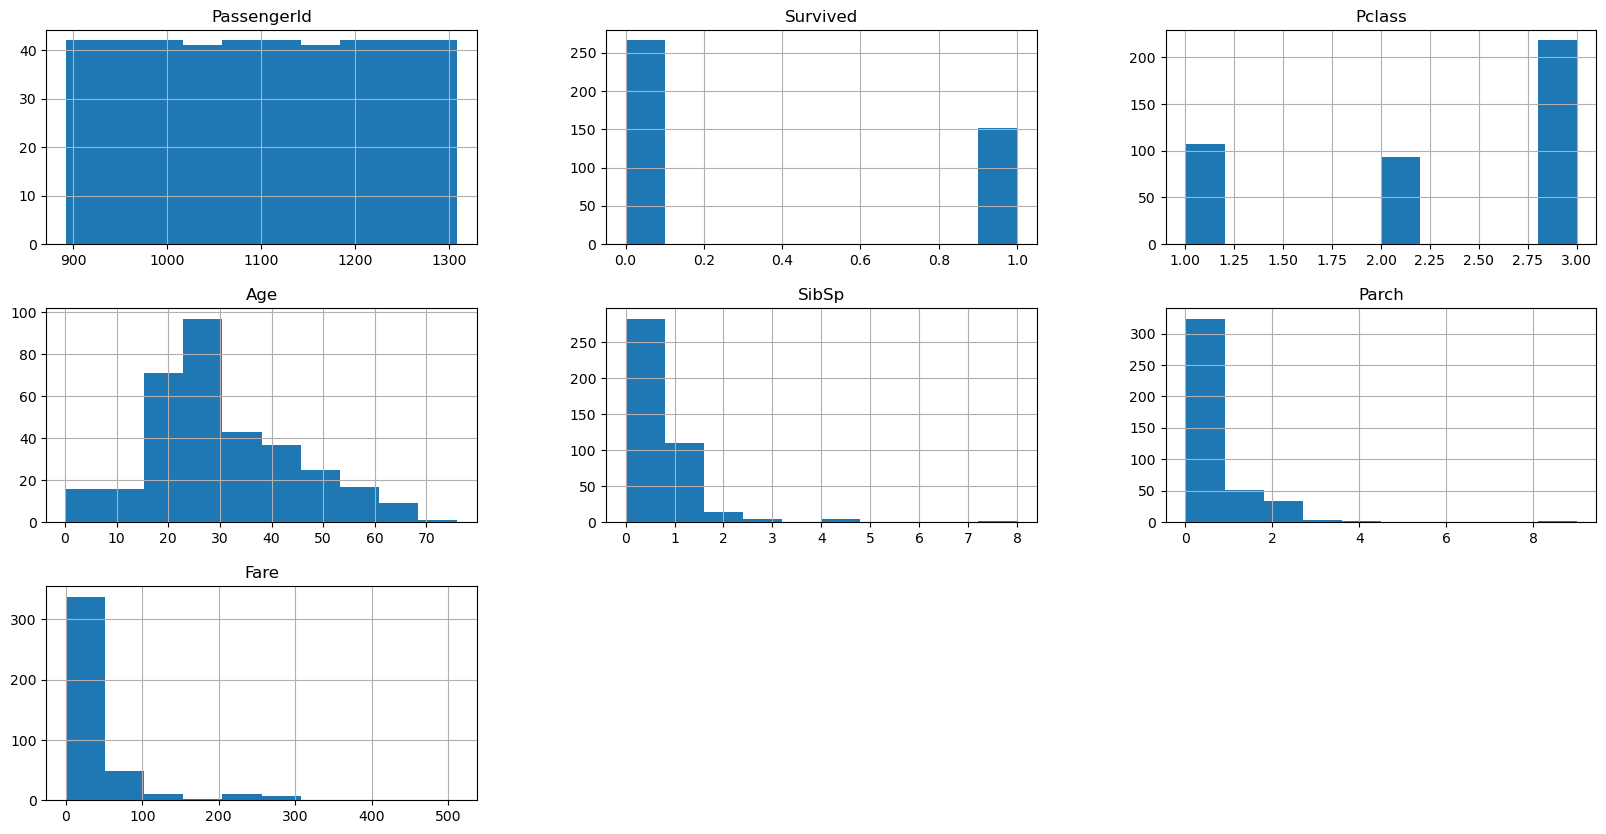

In [19]:
df.hist(figsize=(20,10))

### Observed
- Most of the features are left skewed. Hence median is a best strategy for imputation

## Feature Selection


In [22]:
# Set a correlation threshold to identify highly correlated features
correlation_threshold = 0.4  # Adjust as needed
correlation_matrix=df.corr()
# Find highly correlated feature pairs
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

print("Highly correlated features:", highly_correlated_features)

Highly correlated features: {'Fare', 'Age'}


# Pipelining

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer ## HAndle Missing Values
from sklearn.preprocessing import StandardScaler ## Feature Scaling
from sklearn.preprocessing import OneHotEncoder ## categorical to numerical
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [21]:
X=df.drop('Survived',axis=1)
y=df['Survived']

In [29]:
from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [30]:
numerical_cols=['PassengerId','Pclass','Age','SibSp','Parch','Fare']
categorical_cols=['Embarked']

In [31]:
numerical_pipeline=Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='mean')),
        ('scaler',StandardScaler())
    ]
)

categorical_pipeline=Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('onehotencoder',OneHotEncoder())
    ]
)

In [32]:
preprocessor=ColumnTransformer(
    [('numerical_pipeline',numerical_pipeline,numerical_cols),
     ('categorical_pipeline',categorical_pipeline,categorical_cols)
     ],verbose=True,n_jobs=-1
)

In [34]:
X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)

# Hyper parameter tuning

In [35]:
classifier=RandomForestClassifier()
parameters={
    'n_estimators':[100,1000,500],
    'criterion':['gini','entropy','log_loss'],
    'max_features':['sqrt','log2']
}

In [36]:
from sklearn.model_selection import GridSearchCV

gridcv=GridSearchCV(classifier,param_grid=parameters,scoring='accuracy',verbose=3,n_jobs=-1,cv=5)
gridcv.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 1000, 500]},
             scoring='accuracy', verbose=3)

In [37]:
gridcv.best_score_

0.6435097241067391

In [38]:
gridcv.best_params_

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}

Q2



In [39]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Load the Iris dataset (you should replace this with your dataset)
iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize individual classifiers
rf_classifier = RandomForestClassifier(random_state=42)
lr_classifier = LogisticRegression(random_state=42)

# Initialize a Voting Classifier
voting_classifier = VotingClassifier(estimators=[
    ('random_forest', rf_classifier),
    ('logistic_regression', lr_classifier)
], voting='hard')

# Train the ensemble model
voting_classifier.fit(X_train, y_train)

# Make predictions
y_pred = voting_classifier.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


### observation
- Logistic Regression is overfitting. Ridge regression might be useful